# Ambulance service sanity checks

Can we use CCG instead of LSOA?

In [2]:
# Import required packages
from dataclasses import dataclass
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from PIL import Image
import geopandas as gpd

# # Linting
# %load_ext pycodestyle_magic
# %pycodestyle_on

In [30]:
# Define file paths
@dataclass(frozen=True)
class Paths:
    '''Singleton object for storing paths to data and database.'''

    image = './external_images'
    data = './data'
    dir_figures = 'figures'
    
    aace = 'aace-map-all.png'
    pollitt = 'pollitt-map.png'
    hsi_ccg = 'hampshire_southampton_isleofwight_ccg.png'
    scas = 'SCAS-map.png'
    eeas = 'our-station-map.jpg'
    blmk = 'BLMK_Map.png'

    ref_scas_eeas_ccg15 = 'ambo_scas_eeast_ccg15.png'
    ref_scas_eeas_ccg21 = 'ambo_scas_eeast_ccg21.png'

    collated = 'collated_data.csv'
    collated_amb = 'collated_data_amb.csv'

    look_ups = 'look_ups'
    lsoa_to_lad = ('LSOA_(2011)_to_LSOA_(2021)_to_Local_Authority_District' +
                   '_(2022)_Lookup_for_England_and_Wales_(Version_2).csv')
    lad_to_country = ('Local_Authority_District_to_Country_(December_2022)' +
                      '_Lookup_in_the_United_Kingdom.csv')
    lsoa_to_ccg = ('Lower_Layer_Super_Output_Area_(2011)_to_Clinical_' +
                   'Commissioning_Group_to_Local_Authority_District_(April_' +
                   '2021)_Lookup_in_England.csv')
    lsoa_to_ccg15 = ('Lower_Layer_Super_Output_Area_(2011)_to_' +
                     'Clinical_Commissioning_Group_to_' +
                     'Local_Authority_District_(July_2015)_Lookup_in_England.csv')
    lsoa_to_sicbl22 = ('LSOA_(2011)_to_Sub_ICB_Locations_' +
                       '(July_2022)_Lookup_in_England.csv')

    demographic = 'demographic'
    ccg_to_amb = 'ambulance_service_info_ccg_lookup.csv'

    dir_ons_geojson = './data/shapefiles/'
    lsoa11_geojson = 'LSOA_Dec_2011_Boundaries_Generalised_Clipped_BGC_EW_V3.geojson'
    ccg15_geojson = 'Clinical_Commissioning_Groups_July_2015_GCB_in_England_2022.geojson'
    ccg21_geojson = 'Clinical_Commissioning_Groups_April_2021_EN_BGC_2022.geojson'
    sicbl22_geojson = 'SICBL_JUL_2022_EN_BGC.geojson'

    lsoa_ambo_results = 'lsoa_ambo_lookup.csv'
    
    ccg15_amb_lookup = 'ccg15_amb.csv'
    sicbl22_amb_lookup = 'sicbl22_amb.csv'
    ccg21_amb_lookup = 'ccg21_amb.csv'

paths = Paths()

In [4]:
c1 = '#0072B2'
c2 = '#009E73'
c3 = '#F0E442'  # '#D55E00'
c4 = '#56B4E9'  # '#CC79A7'
#, '#F0E442', '#56B4E9'

# Ambulance service colours:
amb_colour = pd.Series({
    'EEAST': c1,
    'EMAS': c2,
    'IWAS': c1,
    'LAS': c4,
    'NEAS': c2,
    'NWAS': c3,
    'SCAS': c3,
    'SECAmb': c2,
    'SWAS': c2,
    'WMAS': c1,
    'YAS': c1,
    'WAST': c4,
})
amb_colour.name = 'amb_colour'

In [5]:
# Create dictionary with guide to full ambulance service names
dict_amb_service_name = {'EMAS': 'East Midlands',
                         'EEAST': 'East of England',
                         'IWAS': 'Isle of Wight',
                         'LAS': 'London',
                         'NEAS': 'North East',
                         'NWAS': 'North West',
                         'SCAS': 'South Central',
                         'SECAmb': 'South East Coast',
                         'WMAS': 'West Midlands',
                         'SWAS': 'South West',
                         'WAST': 'Welsh',
                         'YAS': 'Yorkshire'}

In [6]:
df_annotations = pd.DataFrame(
    [
        ['EEAST', 730000, 280000],
        ['EMAS', 620000, 390000],
        ['IWAS', 510000, 70000],
        ['LAS', 650000, 195000],
        ['NEAS', 500000, 580000],
        ['NWAS', 250000, 450000],
        ['SCAS', 380000, 50000],
        ['SECAmb', 670000, 90000],
        ['SWAS', 170000, 160000],
        ['WMAS', 170000, 270000],
        ['YAS', 570000, 490000],
        ['WAST', 200000, 300000],
    ],
    columns=['ambulance_service', 'x_label', 'y_label']
)

# Add full ambulance service name, based on the data dictionary
df_annotations['label'] = (
    df_annotations['ambulance_service'].map(dict_amb_service_name))

# Add colours
df_annotations['amb_colour'] = (
    df_annotations['ambulance_service'].map(amb_colour))

## LSOA ambulance boundaries

In [7]:
lsoa_amb_data = pd.read_csv(os.path.join(paths.data, paths.lsoa_ambo_results))

lsoa_amb_data.head()

,LSOA11CD,ambulance_service,ambulance_service_name,LSOA11NM
0,E01000001,LAS,London,City of London 001A
1,E01000002,LAS,London,City of London 001B
2,E01000003,LAS,London,City of London 001C
3,E01000005,LAS,London,City of London 001E
4,E01000006,LAS,London,Barking and Dagenham 016A


In [8]:
# Import CCG 2015 boundaries:
gdf_lsoa = gpd.read_file(os.path.join(paths.dir_ons_geojson, paths.lsoa11_geojson))

gdf_lsoa.head()

,FID,LSOA11CD,LSOA11NM,LSOA11NMW,BNG_E,BNG_N,LONG,LAT,GlobalID,geometry
0,1,E01000001,City of London 001A,City of London 001A,532129,181625,-0.097060,51.51810,283b0ead-f8fc-40b6-9a79-1ddd7e5c0758,"POLYGON ((532105.092 182011.231, 532162.491 18..."
1,2,E01000002,City of London 001B,City of London 001B,532480,181699,-0.091970,51.51868,ddce266b-7825-428c-9e0a-df66b0179a55,"POLYGON ((532634.497 181926.016, 532619.141 18..."
2,3,E01000003,City of London 001C,City of London 001C,532245,182036,-0.095230,51.52176,c45e358e-a794-485a-bf76-d96e5d458ea4,"POLYGON ((532135.138 182198.131, 532158.250 18..."
3,4,E01000005,City of London 001E,City of London 001E,533581,181265,-0.076280,51.51452,4ddaf5e4-e47f-4312-89a0-923ffec028a6,"POLYGON ((533808.018 180767.774, 533649.037 18..."
4,5,E01000006,Barking and Dagenham 016A,Barking and Dagenham 016A,544994,184276,0.089318,51.53876,1c04702a-b662-4cfc-aab9-2c3e0f2d5e29,"POLYGON ((545122.049 184314.931, 545271.849 18..."


In [9]:
gdf_lsoa = pd.merge(gdf_lsoa, lsoa_amb_data.drop('LSOA11NM', axis='columns'), on='LSOA11CD', how='left')

Merge LSOA by ambulance service:

In [10]:
gdf_ambo_lsoa = gdf_lsoa.dissolve(by='ambulance_service')

In [11]:
gdf_ambo_lsoa = pd.merge(gdf_ambo_lsoa, amb_colour, left_index=True, right_index=True, how='left')

In [12]:
gdf_ambo_lsoa

,geometry,FID,LSOA11CD,LSOA11NM,LSOA11NMW,BNG_E,BNG_N,LONG,LAT,GlobalID,ambulance_service_name,amb_colour
ambulance_service,,,,,,,,,,,,
EEAST,"MULTIPOLYGON (((504078.594 192959.141, 504011....",15124,E01015589,Peterborough 004A,Peterborough 004A,510040,304962,-0.375540,52.63128,4da3e3bb-97f9-4f95-b211-d7a23ee92eca,East of England,#0072B2
EMAS,"MULTIPOLYGON (((433452.973 296575.368, 432482....",12729,E01013128,North East Lincolnshire 010A,North East Lincolnshire 010A,530082,408684,-0.037650,53.55868,22b372e4-ba8f-4752-b12f-fe4e54f2da11,East Midlands,#009E73
IWAS,"MULTIPOLYGON (((450897.496 75508.595, 450613.3...",16778,E01017282,Isle of Wight 006A,Isle of Wight 006A,458780,90989,-1.168760,50.71555,75c0e1e1-1466-4829-8173-884cceb8ac87,Isle of Wight,#0072B2
LAS,"MULTIPOLYGON (((510797.375 170600.422, 510753....",1,E01000001,City of London 001A,City of London 001A,532129,181625,-0.097060,51.51810,283b0ead-f8fc-40b6-9a79-1ddd7e5c0758,London,#56B4E9
NEAS,"MULTIPOLYGON (((417925.732 515867.666, 417905....",7949,E01008162,Gateshead 027A,Gateshead 027A,426408,562669,-1.589150,54.95797,b3e76190-56be-4134-8bf2-6ac07f305224,North East,#009E73
NWAS,"MULTIPOLYGON (((326050.501 378570.905, 326038....",4643,E01004766,Bolton 005A,Bolton 005A,371177,411551,-2.437000,53.59974,8b29f815-53d4-4b72-9b25-cf2c22b95fc1,North West,#F0E442
SCAS,"MULTIPOLYGON (((431521.123 90539.379, 431498.2...",15779,E01016254,West Berkshire 011A,West Berkshire 011A,459411,164813,-1.147730,51.37926,82b927fc-f1a7-4fe5-9b47-6973a5753472,South Central,#F0E442
SECAmb,"MULTIPOLYGON (((483647.937 93878.803, 483365.4...",15547,E01016016,Medway 015A,Medway 015A,575802,167303,0.524689,51.37755,d760f752-f29d-4462-95db-2d6f94b132e4,South East Coast,#009E73
SWAS,"MULTIPOLYGON (((83892.297 5351.297, 83908.103 ...",13941,E01014370,Bath and North East Somerset 007A,Bath and North East Somerset 007A,375084,165047,-2.359420,51.38391,4559e288-21f3-4d0d-833c-7a5cb3d48133,South West,#009E73


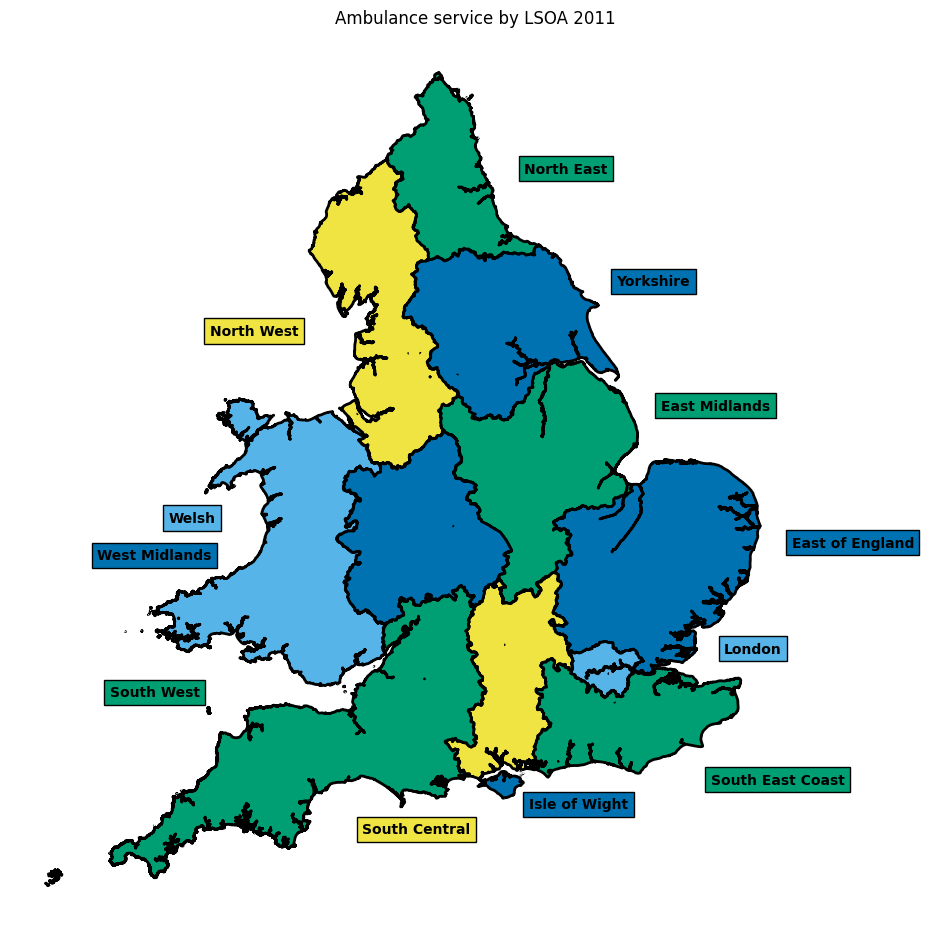

In [13]:
fig, ax = plt.subplots(figsize=(12, 12))

gdf_ambo_lsoa.plot(
    ax=ax,
    color=gdf_ambo_lsoa['amb_colour'],
    # color='none',
    edgecolor='k',
    linewidth=2,
)

for i in range(len(df_annotations)):
    plt.annotate(
        df_annotations.loc[i, 'label'],
        xy=(df_annotations.loc[i, 'x_label'], df_annotations.loc[i, 'y_label']),
        weight='bold',
        bbox=dict(facecolor=df_annotations.loc[i, 'amb_colour']),
        ha='center', va='center'
    )

ax.axis('off')
ax.set_xlim(ax.get_xlim()[0], 800000)

ax.set_title('Ambulance service by LSOA 2011')

plt.savefig(os.path.join(paths.dir_figures, 'ambo_service_lsoa11.png'), bbox_inches='tight')
plt.show()

## Compare with CCG 2015

Can we instead assign ambulance service areas to CCG 2015 regions and get the same results as the LSOA regions?

__Create data__

Import LSOA-CCG15 lookup:

In [14]:
df_lsoa_ccg15 = pd.read_csv(os.path.join(paths.data, paths.look_ups, paths.lsoa_to_ccg15))

In [15]:
df_lsoa_ccg15.head()

,LSOA11CD,LSOA11NM,CCG15CD,CCG15CDH,CCG15NM,LAD15CD,LAD15NM,FID
0,E01010638,Bradford 004A,E38000001,02N,"NHS Airedale, Wharfedale and Craven CCG",E08000032,Bradford,1
1,E01023975,Ashford 007B,E38000002,09C,NHS Ashford CCG,E07000105,Ashford,2
2,E01010639,Bradford 004B,E38000001,02N,"NHS Airedale, Wharfedale and Craven CCG",E08000032,Bradford,3
3,E01023976,Ashford 008A,E38000002,09C,NHS Ashford CCG,E07000105,Ashford,4
4,E01023977,Ashford 007C,E38000002,09C,NHS Ashford CCG,E07000105,Ashford,5


Import a CCG15-ambulance service lookup that we've invented:

In [16]:
# Build ambulance service shapes from CCG 2015:
df_ccg15_ambo = pd.read_csv(os.path.join(paths.data, paths.ccg15_amb_lookup))

df_ccg15_ambo

,ccg15nm,ambulance_service_code
0,NHS Basildon and Brentwood CCG,EEAST
1,NHS Bedfordshire CCG,EEAST
2,NHS Cambridgeshire and Peterborough CCG,EEAST
3,NHS Castle Point and Rochford CCG,EEAST
4,NHS East and North Hertfordshire CCG,EEAST
...,...,...
204,NHS Rotherham CCG,YAS
205,NHS Scarborough and Ryedale CCG,YAS
206,NHS Sheffield CCG,YAS
207,NHS Vale of York CCG,YAS


Create a dataframe containing all LSOA and the ambulance service from the CCG2015 lookup:

In [17]:
df_lsoa_ccg15_ambo = pd.merge(
    df_lsoa_ccg15, df_ccg15_ambo,
    left_on='CCG15NM', right_on='ccg15nm', how='left'
)

__Compare data__

Create a dataframe containing all LSOA. One column will have the ambulance service data as defined previously on the LSOA-level, and another column will have the ambulance service data as defined by the CCG 2015.

In [18]:
df_lsoa_compare = pd.merge(
    lsoa_amb_data[['LSOA11NM', 'LSOA11CD', 'ambulance_service']],
    df_lsoa_ccg15_ambo[['LSOA11CD', 'ambulance_service_code']],
    on='LSOA11CD', how='right'
)

In [19]:
df_lsoa_compare.head()

,LSOA11NM,LSOA11CD,ambulance_service,ambulance_service_code
0,Bradford 004A,E01010638,YAS,YAS
1,Ashford 007B,E01023975,SECAmb,SECAmb
2,Bradford 004B,E01010639,YAS,YAS
3,Ashford 008A,E01023976,SECAmb,SECAmb
4,Ashford 007C,E01023977,SECAmb,SECAmb


Do the ambulance service columns differ for any LSOA?

In [20]:
mask_diff = df_lsoa_compare['ambulance_service'] != df_lsoa_compare['ambulance_service_code']

In [21]:
mask_diff.any()

False

The two columns are always the same, so we can use CCG 2015 to define the ambulance service boundaries!

### Plot ambulance service regions using CCG 2015

In [22]:
# Import CCG 2015 boundaries:
gdf_ccg15 = gpd.read_file(os.path.join(paths.dir_ons_geojson, paths.ccg15_geojson))

In [23]:
gdf_amb = pd.merge(gdf_ccg15, df_ccg15_ambo, on='ccg15nm', how='left')

In [24]:
# Merge ccg boundaries:
gdf_amb = gdf_amb.dissolve(by='ambulance_service_code')

In [25]:
# Merge in colours:
gdf_amb['colour'] = gdf_amb.index.map(amb_colour)

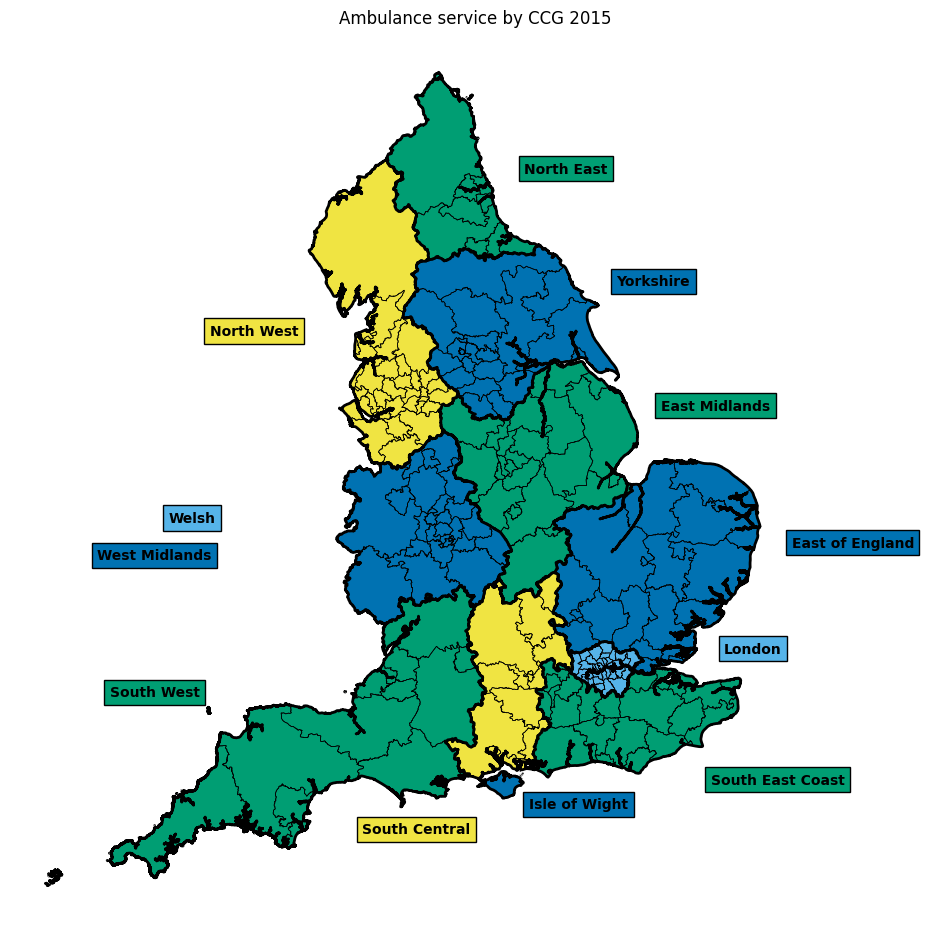

In [26]:
fig, ax = plt.subplots(figsize=(12, 12))

gdf_amb.plot(
    ax=ax,
    color=gdf_amb['colour'],
    # color='none',
    edgecolor='k',
    linewidth=2,
)

gdf_ccg15.plot(
    ax=ax,
    color='none',
    edgecolor='k',
    linewidth=0.5,
)

for i in range(len(df_annotations)):
    plt.annotate(
        df_annotations.loc[i, 'label'],
        xy=(df_annotations.loc[i, 'x_label'], df_annotations.loc[i, 'y_label']),
        weight='bold',
        bbox=dict(facecolor=df_annotations.loc[i, 'amb_colour']),
        ha='center', va='center'
    )

ax.axis('off')
ax.set_xlim(ax.get_xlim()[0], 800000)

ax.set_title('Ambulance service by CCG 2015')

plt.savefig(os.path.join(paths.dir_figures, 'ambo_service_ccg15.png'), bbox_inches='tight')
plt.show()

## Compare with SICBL 2022

Most other geography lookup files we've created for stroke projects use SICBL 2022. Check whether the boundary changes from CCG 2021 to SICBL 2022 affect the ambulance service boundaries.

Yes they do - to do, make a changelog of LSOA that changed. Affects near Manchester/Derbyshire and near Kettering/Peterborough.

Import an LSOA-SICBL lookup:

In [97]:
df_lsoa_sicbl22 = pd.read_csv(os.path.join(paths.data, paths.look_ups, paths.lsoa_to_sicbl22))

df_lsoa_sicbl22 = df_lsoa_sicbl22.drop(['FID', 'SICBL22CDH'], axis='columns')

df_lsoa_sicbl22.head()

,LSOA11CD,LSOA11NM,SICBL22CD,SICBL22NM
0,E01012367,Halton 007A,E38000068,NHS Cheshire and Merseyside ICB - 01F
1,E01012368,Halton 003A,E38000068,NHS Cheshire and Merseyside ICB - 01F
2,E01012369,Halton 005A,E38000068,NHS Cheshire and Merseyside ICB - 01F
3,E01012370,Halton 007B,E38000068,NHS Cheshire and Merseyside ICB - 01F
4,E01012371,Halton 016A,E38000068,NHS Cheshire and Merseyside ICB - 01F


Import a SICBL22-ambulance service lookup that we've invented:

In [156]:
# Build ambulance service shapes from SICBL 2022:
df_sicbl22_ambo = pd.read_csv(os.path.join(paths.data, paths.sicbl22_amb_lookup))

df_sicbl22_ambo

,LOC22CD,LOC22NM,ambulance_service_code
0,E38000260,NHS Cambridgeshire and Peterborough ICB - 06H,EEAST
1,E38000049,NHS Hertfordshire and West Essex ICB - 06K,EEAST
2,E38000079,NHS Hertfordshire and West Essex ICB - 06N,EEAST
3,E38000197,NHS Hertfordshire and West Essex ICB - 07H,EEAST
4,E38000106,NHS Mid and South Essex ICB - 06Q,EEAST
...,...,...,...
101,E38000025,NHS West Yorkshire ICB - 02T,YAS
102,E38000190,NHS West Yorkshire ICB - 03R,YAS
103,E38000225,NHS West Yorkshire ICB - 15F,YAS
104,E38000232,NHS West Yorkshire ICB - 36J,YAS


### Check changes from CCG 2021 to SICBL 2022

Check if the problem CCGs are unchanged between 2021 and 2022. If they are unchanged then their codes will be the same.

In [99]:
print(df_ccg21_ambo.loc[df_ccg21_ambo['CCG21NM'] == 'NHS Hampshire, Southampton and Isle of Wight CCG', 'CCG21CD'].values[0])
print(df_sicbl22_ambo.loc[df_sicbl22_ambo['LOC22NM'] == 'NHS Hampshire and Isle of Wight ICB - D9Y0V', 'LOC22CD'].values[0])

E38000253
E38000253


In [100]:
print(df_ccg21_ambo.loc[df_ccg21_ambo['CCG21NM'] == 'NHS Bedfordshire, Luton and Milton Keynes CCG', 'CCG21CD'].values[0])
print(df_sicbl22_ambo.loc[df_sicbl22_ambo['LOC22NM'] == 'NHS Bedfordshire, Luton and Milton Keynes ICB - M1J4Y', 'LOC22CD'].values[0])

E38000249
E38000249


The region boundaries did not change between 2021 and 2022 so we can use the same LSOA-level ambulance service lookup for both.

### Make LSOA-level ambulance lookup for SICBL 2022

Use the LSOA-SICBL22 and SICBL22-ambo lookups for all regions except those containing Milton Keynes and the Isle of Wight.

In [101]:
df_lsoa_ambo22 = pd.merge(
    df_lsoa_sicbl22, df_sicbl22_ambo,
    left_on='SICBL22CD', right_on='LOC22CD',
    how='left'
)

df_lsoa_ambo22 = df_lsoa_ambo22.drop(['LOC22CD', 'LOC22NM'], axis='columns')

In [102]:
df_lsoa_ambo22.head()

,LSOA11CD,LSOA11NM,SICBL22CD,SICBL22NM,ambulance_service_code
0,E01012367,Halton 007A,E38000068,NHS Cheshire and Merseyside ICB - 01F,NWAS
1,E01012368,Halton 003A,E38000068,NHS Cheshire and Merseyside ICB - 01F,NWAS
2,E01012369,Halton 005A,E38000068,NHS Cheshire and Merseyside ICB - 01F,NWAS
3,E01012370,Halton 007B,E38000068,NHS Cheshire and Merseyside ICB - 01F,NWAS
4,E01012371,Halton 016A,E38000068,NHS Cheshire and Merseyside ICB - 01F,NWAS


Separately add in the data for regions containing Milton Keynes and the Isle of Wight:

In [103]:
# Replace "multiple" ambulance service code with missing value:
df_lsoa_ambo22.loc[df_lsoa_ambo22['ambulance_service_code'] == 'multiple', 'ambulance_service_code'] = pd.NA

In [ ]:
# Merge in ambulance service from the CCG21 lookup.

# Set both the 2021 and 2022 data to share an index column (LSOA 2011 codes)
# and the ambulance service column name.
# Also remove excess columns from the 2021 data.
df21 = lsoa_amb_data.rename(
    columns={'ambulance_service': 'ambulance_service_code'}
).set_index('LSOA11CD')[['LSOA11NM', 'ambulance_service_code']]

df22 = df_lsoa_ambo22.set_index('LSOA11CD')

# Take the data from 2022 unless it is missing, in which case use 2021:
df_lsoa_amb22 = df22.combine_first(df21)#, axis='columns')

In [119]:
df_lsoa_amb22

,LSOA11NM,SICBL22CD,SICBL22NM,ambulance_service_code
LSOA11CD,,,,
E01000001,City of London 001A,E38000255,NHS North East London ICB - A3A8R,LAS
E01000002,City of London 001B,E38000255,NHS North East London ICB - A3A8R,LAS
E01000003,City of London 001C,E38000255,NHS North East London ICB - A3A8R,LAS
E01000005,City of London 001E,E38000255,NHS North East London ICB - A3A8R,LAS
E01000006,Barking and Dagenham 016A,E38000255,NHS North East London ICB - A3A8R,LAS
...,...,...,...,...
W01001954,Cardiff 006F,NaN,NaN,WAST
W01001955,Swansea 025F,NaN,NaN,WAST
W01001956,Swansea 023E,NaN,NaN,WAST


In [120]:
df_lsoa_amb22['ambulance_service_code'].isna().any()

False

### Plot ambulance service regions using SICBL 2022

Combine the SICBL 2022 shapes for most of England with the CCG 2015 shapes in the problem counties.

In [237]:
# Import CCG 2015 boundaries:
gdf_sicbl22 = gpd.read_file(os.path.join(paths.dir_ons_geojson, paths.sicbl22_geojson))

Merge in ambulance service names:

In [238]:
gdf_amb22 = pd.merge(
    gdf_sicbl22, df_sicbl22_ambo,
    left_on='SICBL22CD', right_on='LOC22CD', how='left'
)

In [239]:
gdf_amb22

,SICBL22CD,SICBL22NM,BNG_E,BNG_N,LONG,LAT,OBJECTID,GlobalID,geometry,LOC22CD,LOC22NM,ambulance_service_code
0,E38000006,NHS South Yorkshire ICB - 02P,429979,403330,-1.549250,53.52580,1,32649d0f-f9d3-4108-a109-0fea4cd3af00,"POLYGON ((443219.660 409833.090, 443286.853 40...",E38000006,NHS South Yorkshire ICB - 02P,YAS
1,E38000007,NHS Mid and South Essex ICB - 99E,564014,194421,0.368068,51.62470,2,f8f0102e-9c60-42ef-980d-cb0c67b4b161,"MULTIPOLYGON (((576454.010 184830.650, 576417....",E38000007,NHS Mid and South Essex ICB - 99E,EEAST
2,E38000008,NHS Nottingham and Nottinghamshire ICB - 02Q,468073,384833,-0.978700,53.35602,3,358ec7e7-3a4c-4f5c-b51f-cffa8666f71e,"MULTIPOLYGON (((482031.031 373911.312, 482015....",E38000008,NHS Nottingham and Nottinghamshire ICB - 02Q,EMAS
3,E38000014,NHS Lancashire and South Cumbria ICB - 00Q,369490,422806,-2.463600,53.70080,4,040bee0e-ef4b-48e0-9c00-85d5d6f277b0,"POLYGON ((375568.596 419018.000, 375716.000 41...",E38000014,NHS Lancashire and South Cumbria ICB - 00Q,NWAS
4,E38000015,NHS Lancashire and South Cumbria ICB - 00R,332819,436634,-3.021990,53.82163,5,1b7b594e-5ad6-4d54-9c5d-0b35db59e5af,"POLYGON ((330412.692 431644.274, 330370.900 43...",E38000015,NHS Lancashire and South Cumbria ICB - 00R,NWAS
...,...,...,...,...,...,...,...,...,...,...,...,...
101,E38000258,NHS Birmingham and Solihull ICB - 15E,412791,287491,-1.813060,52.48520,102,c9961cfa-b78b-41c0-b911-0e54fdfa47eb,"POLYGON ((414454.004 298914.682, 414428.594 29...",E38000258,NHS Birmingham and Solihull ICB - 15E,WMAS
102,E38000259,NHS Black Country ICB - D2P2L,397406,292506,-2.039660,52.53043,103,1b15b0a6-bf9e-426e-b852-093561808460,"POLYGON ((408730.897 298576.695, 408496.813 29...",E38000259,NHS Black Country ICB - D2P2L,WMAS
103,E38000260,NHS Cambridgeshire and Peterborough ICB - 06H,536856,268346,0.005437,52.29621,104,e295fc4a-eea2-49bb-9e89-ea5fb90a8870,"POLYGON ((546684.864 317833.975, 546682.803 31...",E38000260,NHS Cambridgeshire and Peterborough ICB - 06H,EEAST
104,E38000261,NHS Derby and Derbyshire ICB - 15M,426752,353558,-1.602100,53.07860,105,2b3f527a-46a1-4c78-9dc9-cee3ec1ee2cb,"POLYGON ((411883.906 402726.312, 411860.313 40...",E38000261,NHS Derby and Derbyshire ICB - 15M,EMAS


In [252]:
# Pick out the polygons in the Hampshire SICBL:
hants_polys = gdf_amb22.loc[gdf_amb22['SICBL22NM'] == 'NHS Hampshire and Isle Of Wight ICB - D9Y0V']['geometry'].explode()

# Pick out the y-coordinates of each polygon:
hants_polys_y = [p.exterior.coords.xy[1] for p in hants_polys.values]

# Pick out the most southernly y-coordinate of each polygon:
hants_polys_ymin = [min(ys) for ys in hants_polys_y]

# Which polygon is the most southernly?
ind_iow = hants_polys_ymin.index(min(hants_polys_ymin))

/tmp/ipykernel_6601/1884615847.py:2: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  hants_polys = gdf_amb22.loc[gdf_amb22['SICBL22NM'] == 'NHS Hampshire and Isle Of Wight ICB - D9Y0V']['geometry'].explode()


In [254]:
# Add a new geometry row to the main gdf with this polygon:
ind_new = len(gdf_amb22)
gdf_amb22.at[ind_new, 'geometry'] = hants_polys.iloc[ind_iow]
gdf_amb22.at[ind_new, 'ambulance_service_code'] = 'IWAS'

In [256]:
# Check that this added onto the bottom:
gdf_amb22.tail()

,SICBL22CD,SICBL22NM,BNG_E,BNG_N,LONG,LAT,OBJECTID,GlobalID,geometry,LOC22CD,LOC22NM,ambulance_service_code
102,E38000259,NHS Black Country ICB - D2P2L,397406.0,292506.0,-2.039660,52.53043,103.0,1b15b0a6-bf9e-426e-b852-093561808460,"POLYGON ((408730.897 298576.695, 408496.813 29...",E38000259,NHS Black Country ICB - D2P2L,WMAS
103,E38000260,NHS Cambridgeshire and Peterborough ICB - 06H,536856.0,268346.0,0.005437,52.29621,104.0,e295fc4a-eea2-49bb-9e89-ea5fb90a8870,"POLYGON ((546684.864 317833.975, 546682.803 31...",E38000260,NHS Cambridgeshire and Peterborough ICB - 06H,EEAST
104,E38000261,NHS Derby and Derbyshire ICB - 15M,426752.0,353558.0,-1.602100,53.07860,105.0,2b3f527a-46a1-4c78-9dc9-cee3ec1ee2cb,"POLYGON ((411883.906 402726.312, 411860.313 40...",E38000261,NHS Derby and Derbyshire ICB - 15M,EMAS
105,E38000262,NHS Northamptonshire ICB - 78H,477359.0,268708.0,-0.866680,52.31105,106.0,689c41b3-9712-4e43-96cb-4eae3a4fb2d5,"POLYGON ((501933.219 305782.094, 501950.096 30...",E38000262,NHS Northamptonshire ICB - 78H,EMAS
106,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"POLYGON ((448885.247 96629.434, 449349.360 965...",NaN,NaN,IWAS


In [ ]:
# Remove this polygon from the bigger list...
inds_to_keep = list(range(len(hants_polys)))
del inds_to_keep[ind_iow]

hants_polys = hants_polys.iloc[inds_to_keep]

In [265]:
hants_polys

96  0     POLYGON ((431544.157 90574.796, 431529.329 905...
    1     POLYGON ((421795.467 93122.597, 421797.293 931...
    2     POLYGON ((463982.570 93761.793, 463966.771 937...
    4     POLYGON ((443815.904 98038.096, 443640.004 978...
    5     POLYGON ((469905.649 103416.680, 469957.913 10...
    6     POLYGON ((469523.507 103778.142, 469539.861 10...
    7     POLYGON ((468852.748 104190.568, 468829.606 10...
    8     POLYGON ((472814.822 104432.447, 472959.654 10...
    9     POLYGON ((470146.356 104366.997, 470158.437 10...
    10    POLYGON ((474427.148 104480.471, 474385.997 10...
    11    POLYGON ((468963.977 104432.799, 468952.496 10...
    12    POLYGON ((469160.900 104757.600, 469164.216 10...
    13    POLYGON ((469054.614 104844.347, 469037.313 10...
    14    POLYGON ((469116.919 104964.084, 469157.429 10...
    15    POLYGON ((469088.422 105063.534, 469086.932 10...
    16    POLYGON ((469029.808 105123.138, 469024.402 10...
    17    POLYGON ((464131.906 164354.70

In [272]:
hants_polys

96  0     POLYGON ((431544.157 90574.796, 431529.329 905...
    1     POLYGON ((421795.467 93122.597, 421797.293 931...
    2     POLYGON ((463982.570 93761.793, 463966.771 937...
    4     POLYGON ((443815.904 98038.096, 443640.004 978...
    5     POLYGON ((469905.649 103416.680, 469957.913 10...
    6     POLYGON ((469523.507 103778.142, 469539.861 10...
    7     POLYGON ((468852.748 104190.568, 468829.606 10...
    8     POLYGON ((472814.822 104432.447, 472959.654 10...
    9     POLYGON ((470146.356 104366.997, 470158.437 10...
    10    POLYGON ((474427.148 104480.471, 474385.997 10...
    11    POLYGON ((468963.977 104432.799, 468952.496 10...
    12    POLYGON ((469160.900 104757.600, 469164.216 10...
    13    POLYGON ((469054.614 104844.347, 469037.313 10...
    14    POLYGON ((469116.919 104964.084, 469157.429 10...
    15    POLYGON ((469088.422 105063.534, 469086.932 10...
    16    POLYGON ((469029.808 105123.138, 469024.402 10...
    17    POLYGON ((464131.906 164354.70

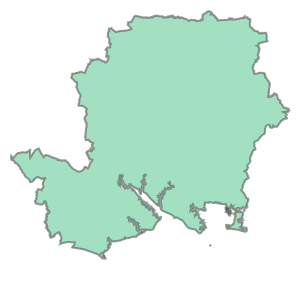

In [273]:
hants_polys.unary_union  # renamed to union_all() in geopandas X

In [270]:
gpd.__version__

'0.12.2'

In [266]:
# Place this reduced list back into the starting gdf:
gdf_amb22.loc[gdf_amb22['SICBL22NM'] == 'NHS Hampshire and Isle Of Wight ICB - D9Y0V']['geometry'] = hants_polys.values

ValueError: Length of values (17) does not match length of index (1)

In [262]:
inds_to_keep = list(range(len(hants_polys)))
del inds_to_keep[ind_iow]

inds_to_keep

[0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17]

In [251]:
hants_polys_ymin

[90535.7061999999,
 93115.5397999994,
 93745.1492999997,
 75258.75,
 97708.9003999997,
 102962.437000001,
 103348.396,
 104183.609200001,
 97972.8310000002,
 103805.069,
 104394.119999999,
 104408.4464,
 104391.169,
 104800.4979,
 104821.443,
 104954.300000001,
 105055.041999999,
 89700.1196999997]

In [249]:
hants_polys_y

[array('d', [90574.7961999997, 90535.7061999999, 90563.3289999999, 90621.5079999994, 90614.2589999996, 90574.7961999997]),
 array('d', [93122.5966999996, 93115.5397999994, 93128.4220000003, 93133.0371000003, 93122.5966999996]),
 array('d', [93761.7928999998, 93745.1492999997, 93756.4193999991, 93771.5407999996, 93790.2324999999, 93805.9726999998, 93795.5320999995, 93779.7871000003, 93761.7928999998]),
 array('d', [96629.4342, 96578.9000000004, 96597.2303999998, 96585.8407000005, 96584.6699999999, 96579.2808999997, 96552.3000000007, 96504.6045999993, 96462.8897999991, 96376.4000000004, 96249.8800000008, 96258.7995999996, 96212.9839999992, 96214.0, 96156.0265999995, 96134.4740999993, 96132.8147999998, 96088.2300000004, 96088.4100000001, 96092.7563000005, 96089.0188999996, 96088.4399999995, 96074.9441999998, 96035.4000000004, 96035.6677999999, 95968.3100000005, 95915.5500000007, 95849.6654000003, 95843.8225999996, 95831.1500000004, 95862.25, 95812.9000000004, 95861.9000000004, 95817.23000

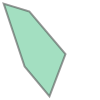

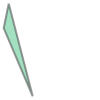

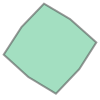

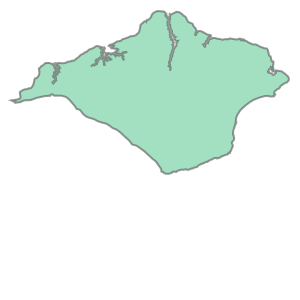

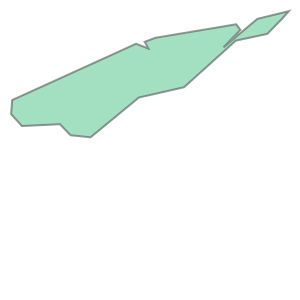

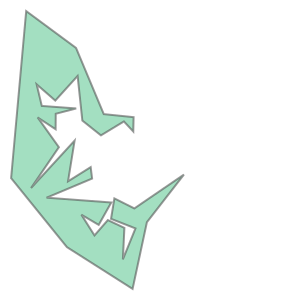

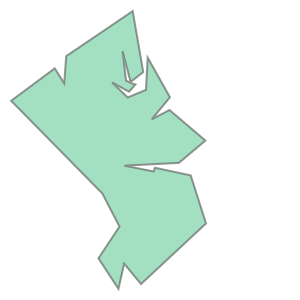

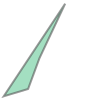

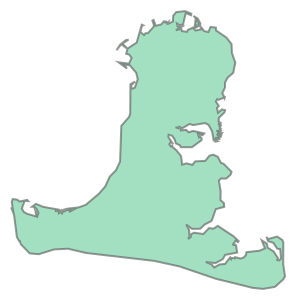

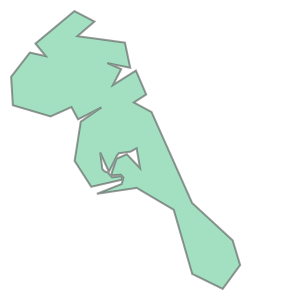

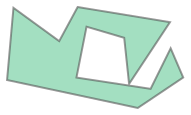

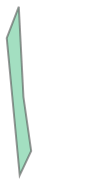

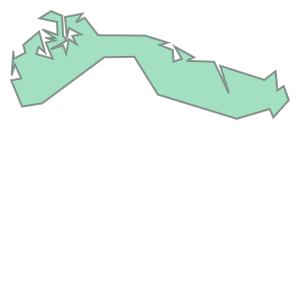

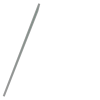

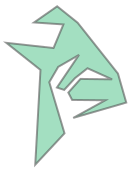

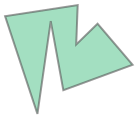

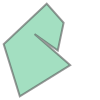

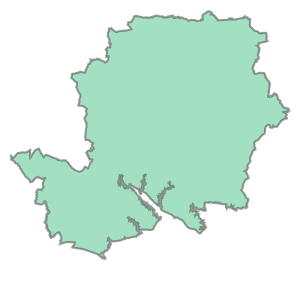

In [244]:
for p in hants_polys.values:
    display(p)

Remove problem counties:

In [221]:
mask = gdf_amb22['SICBL22NM'].isin([
    'NHS Bedfordshire, Luton and Milton Keynes ICB - M1J4Y',
    'NHS Hampshire and Isle Of Wight ICB - D9Y0V'  # note "Of" vs "of" in name
])

gdf_amb22 = gdf_amb22.loc[~mask].copy()

In [222]:
gdf_amb22

,SICBL22CD,SICBL22NM,BNG_E,BNG_N,LONG,LAT,OBJECTID,GlobalID,geometry,LOC22CD,LOC22NM,ambulance_service_code
0,E38000006,NHS South Yorkshire ICB - 02P,429979,403330,-1.549250,53.52580,1,32649d0f-f9d3-4108-a109-0fea4cd3af00,"POLYGON ((443219.660 409833.090, 443286.853 40...",E38000006,NHS South Yorkshire ICB - 02P,YAS
1,E38000007,NHS Mid and South Essex ICB - 99E,564014,194421,0.368068,51.62470,2,f8f0102e-9c60-42ef-980d-cb0c67b4b161,"MULTIPOLYGON (((576454.010 184830.650, 576417....",E38000007,NHS Mid and South Essex ICB - 99E,EEAST
2,E38000008,NHS Nottingham and Nottinghamshire ICB - 02Q,468073,384833,-0.978700,53.35602,3,358ec7e7-3a4c-4f5c-b51f-cffa8666f71e,"MULTIPOLYGON (((482031.031 373911.312, 482015....",E38000008,NHS Nottingham and Nottinghamshire ICB - 02Q,EMAS
3,E38000014,NHS Lancashire and South Cumbria ICB - 00Q,369490,422806,-2.463600,53.70080,4,040bee0e-ef4b-48e0-9c00-85d5d6f277b0,"POLYGON ((375568.596 419018.000, 375716.000 41...",E38000014,NHS Lancashire and South Cumbria ICB - 00Q,NWAS
4,E38000015,NHS Lancashire and South Cumbria ICB - 00R,332819,436634,-3.021990,53.82163,5,1b7b594e-5ad6-4d54-9c5d-0b35db59e5af,"POLYGON ((330412.692 431644.274, 330370.900 43...",E38000015,NHS Lancashire and South Cumbria ICB - 00R,NWAS
...,...,...,...,...,...,...,...,...,...,...,...,...
101,E38000258,NHS Birmingham and Solihull ICB - 15E,412791,287491,-1.813060,52.48520,102,c9961cfa-b78b-41c0-b911-0e54fdfa47eb,"POLYGON ((414454.004 298914.682, 414428.594 29...",E38000258,NHS Birmingham and Solihull ICB - 15E,WMAS
102,E38000259,NHS Black Country ICB - D2P2L,397406,292506,-2.039660,52.53043,103,1b15b0a6-bf9e-426e-b852-093561808460,"POLYGON ((408730.897 298576.695, 408496.813 29...",E38000259,NHS Black Country ICB - D2P2L,WMAS
103,E38000260,NHS Cambridgeshire and Peterborough ICB - 06H,536856,268346,0.005437,52.29621,104,e295fc4a-eea2-49bb-9e89-ea5fb90a8870,"POLYGON ((546684.864 317833.975, 546682.803 31...",E38000260,NHS Cambridgeshire and Peterborough ICB - 06H,EEAST
104,E38000261,NHS Derby and Derbyshire ICB - 15M,426752,353558,-1.602100,53.07860,105,2b3f527a-46a1-4c78-9dc9-cee3ec1ee2cb,"POLYGON ((411883.906 402726.312, 411860.313 40...",E38000261,NHS Derby and Derbyshire ICB - 15M,EMAS


Only keep columns that will be shared with the CCG 2015 data:

In [223]:
gdf_amb22 = gdf_amb22[['geometry', 'ambulance_service_code']]

In [224]:
gdf_amb22.head()

,geometry,ambulance_service_code
0,"POLYGON ((443219.660 409833.090, 443286.853 40...",YAS
1,"MULTIPOLYGON (((576454.010 184830.650, 576417....",EEAST
2,"MULTIPOLYGON (((482031.031 373911.312, 482015....",EMAS
3,"POLYGON ((375568.596 419018.000, 375716.000 41...",NWAS
4,"POLYGON ((330412.692 431644.274, 330370.900 43...",NWAS


Add in CCG 2015 shapes for the problem counties:

In [225]:
# Import CCG 2015 boundaries:
gdf_ccg15 = gpd.read_file(os.path.join(paths.dir_ons_geojson, paths.ccg15_geojson))

gdf_amb15 = pd.merge(gdf_ccg15, df_ccg15_ambo, on='ccg15nm', how='left')

mask = gdf_amb15['ccg15nm'].isin([
    # Hampshire:
    'NHS Isle of Wight CCG',
    'NHS West Hampshire CCG',
    'NHS Southampton CCG',
    'NHS Fareham and Gosport CCG',
    'NHS South Eastern Hampshire CCG',
    'NHS North Hampshire CCG',
    # Bedfordshire:
    'NHS Bedfordshire CCG',
    'NHS Luton CCG',
    'NHS Milton Keynes CCG',
])
gdf_amb15 = gdf_amb15.loc[mask].copy()

gdf_amb15 = gdf_amb15[['geometry', 'ambulance_service_code']]

In [226]:
gdf_amb15

,geometry,ambulance_service_code
9,"POLYGON ((505217.813 270227.845, 505949.188 26...",EEAST
57,"POLYGON ((451479.001 111270.500, 451483.100 11...",SCAS
83,"MULTIPOLYGON (((449620.201 96385.596, 449602.8...",IWAS
98,"POLYGON ((508324.625 226521.391, 508626.612 22...",EEAST
103,"POLYGON ((490000.095 256158.203, 490234.875 25...",SCAS
114,"POLYGON ((464131.906 164354.703, 464254.594 16...",SCAS
148,"MULTIPOLYGON (((483784.000 140116.406, 483782....",SCAS
161,"POLYGON ((441849.828 117537.586, 441921.499 11...",SCAS
192,"MULTIPOLYGON (((433790.597 160140.904, 433941....",SCAS


In [227]:
# n.b. make sure both geodataframe have the same coordinate reference system

gdf_amb22 = pd.concat((gdf_amb22, gdf_amb15), axis='rows')

In [228]:
# Merge ccg boundaries:
gdf_amb22 = gdf_amb22.to_crs('EPSG:4326')
gdf_amb22 = gdf_amb22.dissolve(by='ambulance_service_code')
gdf_amb22 = gdf_amb22.to_crs('EPSG:27700')

In [229]:
# Merge in colours:
gdf_amb22['colour'] = gdf_amb22.index.map(amb_colour)

mask_multi = gdf_amb22['colour'].isna()
gdf_amb22.loc[mask_multi, 'colour'] = '#00000000'

In [230]:
gdf_amb22

,geometry,colour
ambulance_service_code,,
EEAST,"MULTIPOLYGON (((570581.527 181421.563, 570607....",#0072B2
EMAS,"MULTIPOLYGON (((502230.095 305246.806, 502361....",#009E73
IWAS,"MULTIPOLYGON (((429004.600 84837.900, 429056.1...",#0072B2
LAS,"MULTIPOLYGON (((516122.679 172421.288, 516064....",#56B4E9
NEAS,"MULTIPOLYGON (((430957.401 553176.504, 430617....",#009E73
NWAS,"MULTIPOLYGON (((327676.335 373841.265, 327789....",#F0E442
SCAS,"MULTIPOLYGON (((443253.300 97716.200, 443217.3...",#F0E442
SECAmb,"MULTIPOLYGON (((483259.160 95087.406, 483283.1...",#009E73
SWAS,"MULTIPOLYGON (((83907.070 5397.610, 83962.840 ...",#009E73


In [231]:
gdf_amb22_buff = gdf_amb22.copy()

b = 100

ambo = ['SCAS', 'EEAST']
gdf_amb22_buff.loc[ambo, 'geometry'] = gdf_amb22.loc[ambo, 'geometry'].buffer(b).buffer(b)

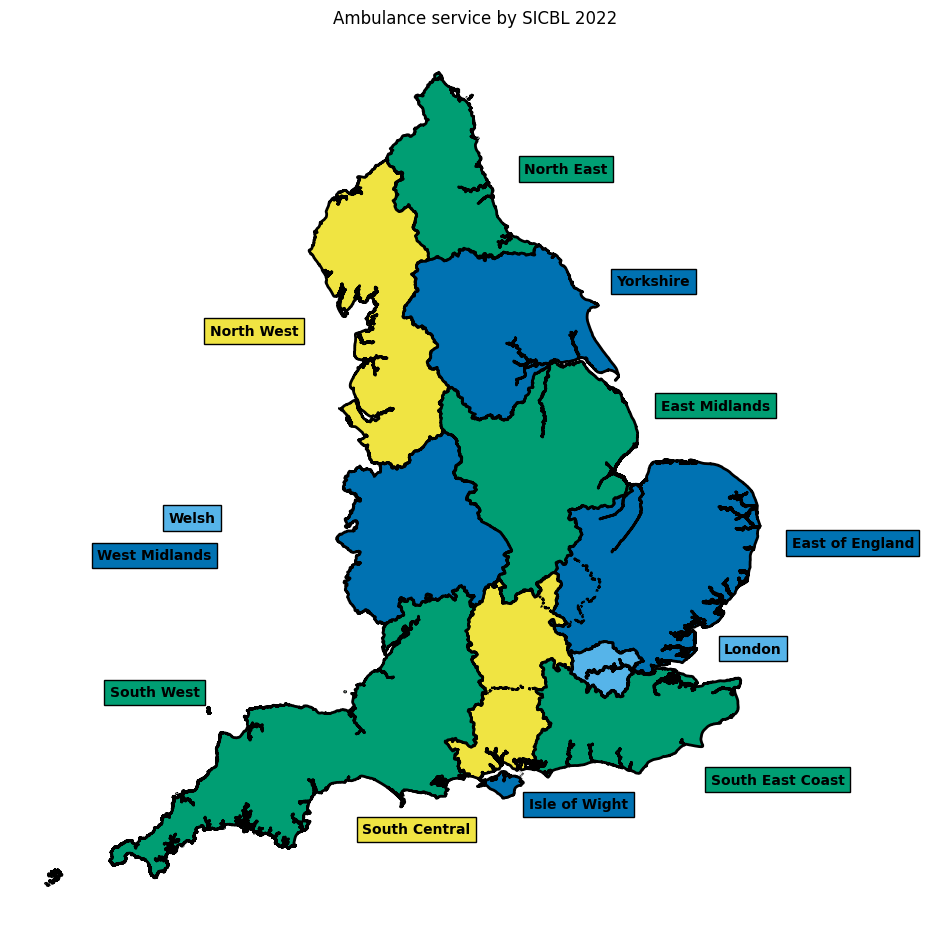

In [236]:
fig, ax = plt.subplots(figsize=(12, 12))

gdf_amb22.plot(
    ax=ax,
    color=gdf_amb22['colour'],
    # color='none',
    edgecolor='k',
    linewidth=2,
)

# gdf_ccg15.plot(
#     ax=ax,
#     color='none',
#     edgecolor='k',
#     linewidth=0.5,
# )

for i in range(len(df_annotations)):
    plt.annotate(
        df_annotations.loc[i, 'label'],
        xy=(df_annotations.loc[i, 'x_label'], df_annotations.loc[i, 'y_label']),
        weight='bold',
        bbox=dict(facecolor=df_annotations.loc[i, 'amb_colour']),
        ha='center', va='center'
    )

ax.axis('off')
ax.set_xlim(ax.get_xlim()[0], 800000)

ax.set_title('Ambulance service by SICBL 2022')

plt.savefig(os.path.join(paths.dir_figures, 'ambo_service_sicbl22.png'), bbox_inches='tight')
plt.show()

In [233]:
gdf_amb

,geometry,OBJECTID,ccg15cd,ccg15nm,GlobalID,colour
ambulance_service_code,,,,,,
EEAST,"MULTIPOLYGON (((573302.999 185046.600, 573355....",7,E38000007,NHS Basildon and Brentwood CCG,e4cb84db-5655-4d5b-aef1-c362ebb1809c,#0072B2
EMAS,"MULTIPOLYGON (((496095.344 290000.000, 496566....",8,E38000008,NHS Bassetlaw CCG,2394f4d4-7c73-40fa-bb36-11ab69b624c7,#009E73
IWAS,"MULTIPOLYGON (((429004.600 84837.900, 429056.1...",84,E38000087,NHS Isle of Wight CCG,9db88928-153d-464a-9e1a-c157177b439f,#0072B2
LAS,"MULTIPOLYGON (((522027.712 166023.608, 521799....",4,E38000004,NHS Barking and Dagenham CCG,5a4e13cd-452f-40b0-bb63-ac89943cc775,#56B4E9
NEAS,"MULTIPOLYGON (((414421.800 565195.000, 414599....",41,E38000042,NHS Darlington CCG,16abe85c-f042-4b6a-9ab6-3d1599e6eb48,#009E73
NWAS,"MULTIPOLYGON (((326050.500 378570.901, 326039....",14,E38000014,NHS Blackburn with Darwen CCG,bab6c853-e9df-4ed7-a5fb-b832ad1254b0,#F0E442
SCAS,"MULTIPOLYGON (((465575.594 94942.172, 465553.0...",3,E38000003,NHS Aylesbury Vale CCG,92a2301c-8bc6-44a4-b09d-0995f98d4fbc,#F0E442
SECAmb,"MULTIPOLYGON (((477021.399 100754.300, 477100....",2,E38000002,NHS Ashford CCG,7cb0f335-98b9-4002-93ee-e16a1311439d,#009E73
SWAS,"MULTIPOLYGON (((83978.100 5378.600, 83945.900 ...",9,E38000009,NHS Bath and North East Somerset CCG,65ed4406-969d-4bc6-bdb8-7268c3c5a6e2,#009E73


## CCG 2021

Import a CCG21-ambulance service lookup that we've invented:

In [234]:
# Build ambulance service shapes from SICBL 2022:
df_ccg21_ambo = pd.read_csv(os.path.join(paths.data, paths.ccg21_amb_lookup))

df_ccg21_ambo

,CCG21CD,CCG21NM,ambulance_service_code
0,E38000007,NHS Basildon and Brentwood CCG,EEAST
1,E38000026,NHS Cambridgeshire and Peterborough CCG,EEAST
2,E38000030,NHS Castle Point and Rochford CCG,EEAST
3,E38000049,NHS East and North Hertfordshire CCG,EEAST
4,E38000079,NHS Herts Valleys CCG,EEAST
...,...,...,...
101,E38000241,NHS North Yorkshire CCG,YAS
102,E38000141,NHS Rotherham CCG,YAS
103,E38000146,NHS Sheffield CCG,YAS
104,E38000188,NHS Vale of York CCG,YAS


In [235]:


# Import CCG 2021 boundaries:
gdf_ccg21 = gpd.read_file(os.path.join(paths.dir_ons_geojson, paths.ccg21_geojson))